# (VAD) Velocity Azimuth Display

Argonne National Laboratory

In [54]:
%%time
import warnings
warnings.filterwarnings("ignore")

import pyart
import numpy.ma as ma
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
from metpy.plots import SkewT

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.96 ms


In [55]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile



def velocity_azimuth_display(radar, vel_field=None, z_want=None,
                             gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)
    
        
    if vel_field is None:
        check_field = radar.check_field_exists('velocity')
        vel_field = get_field_name('velocity')

        
    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation(
            used_velocities, azimuth, elevation)

        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed)
        angles.append(angle)
        heights.append(z_gate_data[index_start, :])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad


def _vad_calculation(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) != True, 0)
    #aa = count < 8
    #vals[:, aa] = 0
    #vals2[:, aa] = 0
    #count = np.float64(count)
    #count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    #count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return np.sin(direction) * speed, np.cos(direction) * speed

In [56]:
#importing xsapr data from i5
radar_file = '/home/jhemedinger/dev_pyart/vad/data/XSW170519052004.RAW54YX'
radar = pyart.io.read(radar_file)
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase'])

In [57]:
#SGP sounding from May 19, 2017
data = Dataset('/home/jhemedinger/dev_pyart/vad/data/sgpsondewnpnC1.b1.20170519.052800.cdf', 'r')
pressure = data.variables['pres'][:]
temperature = data.variables['tdry'][:]
dewpoint = data.variables['dp'][:]
u_wind = data.variables['u_wind'][:]
v_wind = data.variables['v_wind'][:]
speed = data.variables['wspd'][:]
degree = data.variables['deg'][:]
height = data.variables['alt'][:]

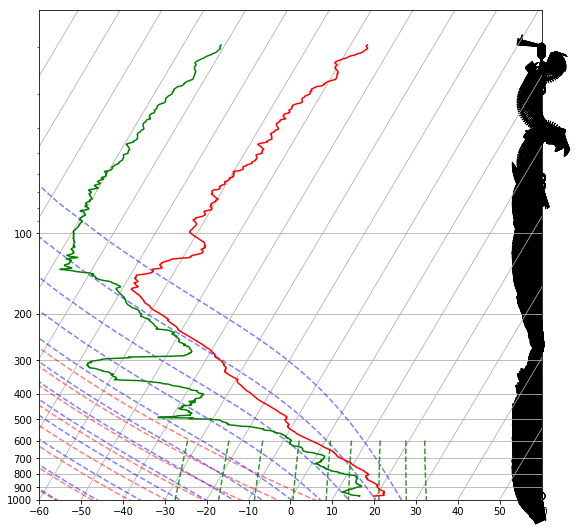

In [58]:
fig = plt.figure(figsize=(9,9))
skew = SkewT(fig)
skew.plot(pressure,temperature,'r')
skew.plot(pressure,dewpoint,'g')
skew.plot_barbs(pressure[:-1:2], u_wind[:-1:2], v_wind[:-1:2])
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000,0)
skew.ax.set_xlim(-60,60)
#prof = metcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
#skew.plot(pressure, prof, '--k', linewidth=2)
#plt.title('KILX ROAB Obs 00 UTC 27 June 2018', loc='center')
#plt.savefig('/home/jhemedinger/suli_projects/chicago-nowcast/images/ilx_sounding_00UTC.png', dpi=300)
plt.show()

In [59]:
#corr_vel = pyart.correct.dealias_region_based(
#    radar, vel_field='velocity', keep_original=False, 
#    gatefilter=gatefilter, centered=True)
#radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

In [60]:
hprofile = pyart.core.HorizontalWindProfile.from_u_and_v(height, u_wind, v_wind)
sim_vel = pyart.util.simulated_vel_from_profile(radar, hprofile)
radar.add_field('sim_velocity', sim_vel, replace_existing=True)

In [61]:
#gatefilter = pyart.correct.GateFilter(radar)
#gatefilter.exclude_below('reflectivity', 5)
#gatefilter.exclude_invalid('sim_velocity')

In [62]:
minimum = np.min(height)
maximum = np.max(height)
shape = np.shape(height)
print(minimum, maximum, shape)

314.8 26766.8 (4953,)


In [63]:
z_want = np.linspace(314.8, 26766.8, 4953)

In [64]:
#vad = velocity_azimuth_display(radar, 'sim_velocity', z_want=z_want)
vad = pyart.retrieve.velocity_azimuth_display(radar, 'sim_velocity', 
                                             z_want=z_want)

max height 705.0 meters
max height 1457.0 meters
max height 2336.0 meters
max height 3207.0 meters
max height 4073.0 meters
max height 4950.0 meters
max height 5827.0 meters
max height 6678.0 meters
max height 7549.0 meters
max height 8416.0 meters
max height 9275.0 meters
max height 10125.0 meters
max height 10978.0 meters
max height 12257.0 meters
max height 13100.0 meters
max height 14772.0 meters
max height 17242.0 meters
max height 21264.0 meters
max height 25129.0 meters
max height 32222.0 meters
max height 38355.0 meters
max height 40989.0 meters
max height 43312.0 meters


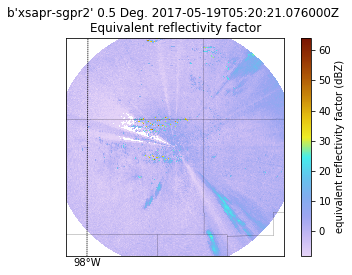

In [65]:
display = pyart.graph.RadarMapDisplay(radar)

display.plot_ppi_map('reflectivity', sweep=0, resolution='l', 
                     vmin=-8, vmax=64, mask_outside=True, 
                     width=90000, height=90000, 
                     cmap=pyart.graph.cm.LangRainbow12)
display.basemap.drawcounties()

plt.show()
plt.close()

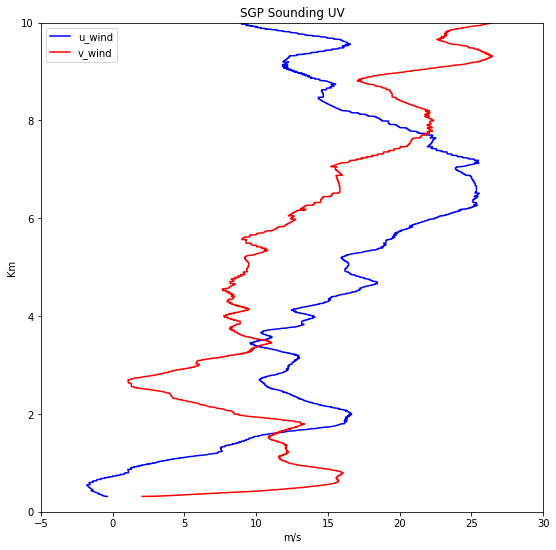

In [66]:
fig = plt.figure(figsize=(9,9))
plt.plot(u_wind, height/1000, '-b', label='u_wind')
plt.plot(v_wind, height/1000, '-r', label='v_wind')
plt.legend(loc=0)
plt.xlim(-5,30)
plt.ylim(0,10)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('SGP Sounding UV')
#plt.savefig('sgp_sounding_uv', dpi=300)
plt.show()

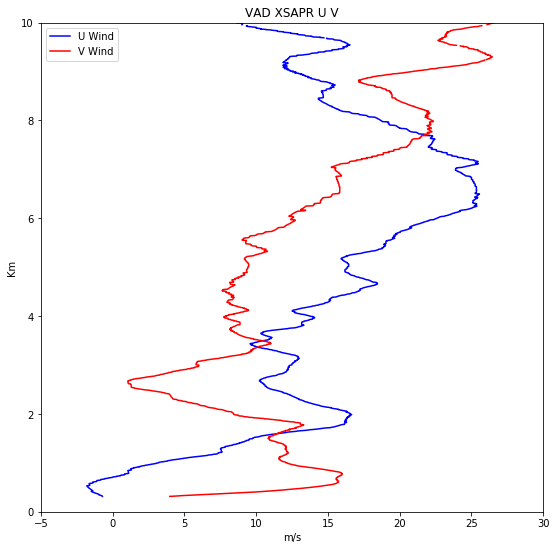

In [67]:
fig = plt.figure(figsize=(9,9))
plt.plot(vad.u_wind, vad.height/1000, 'b-', label='U Wind')
plt.plot(vad.v_wind, vad.height/1000, 'r-', label='V Wind')
plt.xlim(-5, 30)
plt.ylim(0, 10)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD XSAPR U V')
plt.legend(loc=0)
#plt.savefig('vad_xsapr_uv_zline_default', dpi=300)
plt.show()

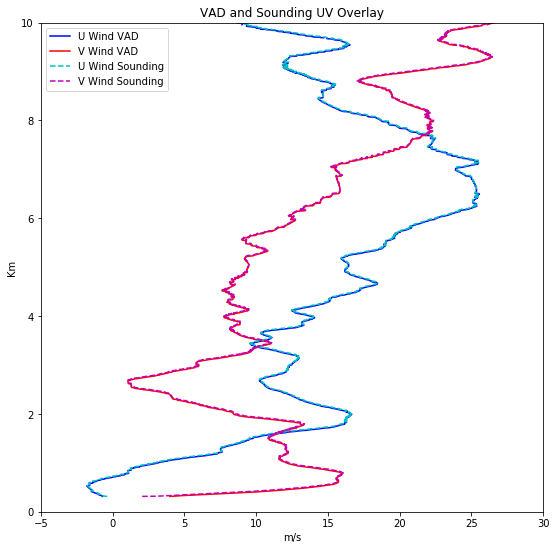

In [68]:
fig = plt.figure(figsize=(9,9))
plt.plot(vad.u_wind[:], vad.height[:]/1000, 'b-', label='U Wind VAD')
plt.plot(vad.v_wind[:], vad.height[:]/1000, 'r-', label='V Wind VAD')
plt.plot(u_wind[:], height[:]/1000, 'c--', label='U Wind Sounding')
plt.plot(v_wind[:], height[:]/1000, 'm--', label='V Wind Sounding')
plt.xlim(-5, 30)
plt.ylim(0, 10)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD and Sounding UV Overlay')
plt.legend(loc=0)
#plt.savefig('vad_sounding_uv_overlay', dpi=300)
plt.show()

In [16]:
""" Unit Tests for Py-ART's retrieve/vad.py module. """
from numpy.testing import assert_almost_equal

In [17]:
def test_velocity_azimuth_display():
    test_radar = pyart.testing.make_target_radar()
    height = np.arange(0, 1000, 200)
    speed = np.ones_like(height) * 5
    direction = np.array([0, 90, 180, 270, 45])
    profile = pyart.core.HorizontalWindProfile(height, speed, direction)
    sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
    test_radar.add_field('velocity', sim_vel,
                         replace_existing=True)

    velocity = 'velocity'
    z_want = np.linspace(0, 10, 5)

    vad_height = ([0., 2.5, 5., 7.5, 10.])
    vad_speed = ([4.9997185, 4.94454562, 4.88650695,
                  4.81821108, 4.7497797])
    vad_direction = ([89.87127597, 90.51130701, 91.20841811,
                      92.06222684, 92.95691476])
    u_wind = ([-4.99970588, -4.94434874,
               -4.88542017, -4.8150905, -4.74345588])
    v_wind = ([-0.01123265, 0.04412449,
               0.10305307, 0.17338274, 0.24501735])

    vad = velocity_azimuth_display(
        test_radar, velocity, z_want)

    assert_almost_equal(vad.height, vad_height, 3)
    assert_almost_equal(vad.speed, vad_speed, 3)
    assert_almost_equal(vad.direction, vad_direction, 3)
    assert_almost_equal(vad.u_wind, u_wind, 3)
    assert_almost_equal(vad.v_wind, v_wind, 3)

In [18]:
test_velocity_azimuth_display()

max height 13.0 meters


In [69]:
test_radar = pyart.testing.make_target_radar()
height = np.arange(0, 1000, 200)
speed = np.ones_like(height) * 5
direction = np.array([0, 90, 180, 270, 45])
profile = pyart.core.HorizontalWindProfile(height, speed, direction)
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel,
                     replace_existing=True)

velocity = 'velocity'
z_want = np.linspace(0, 10, 5)

vad = velocity_azimuth_display(
    test_radar, velocity, z_want)
print(vad.height)
print(vad.speed)
print(vad.direction)
print(vad.u_wind)
print(vad.v_wind)

max height 13.0 meters
[ 0.   2.5  5.   7.5 10. ]
[4.9997185  4.94454562 4.88650695 4.81821108 4.7497797 ]
[89.87127597 90.51130701 91.20841811 92.06222684 92.95691476]
[-4.99970588 -4.94434874 -4.88542017 -4.8150905  -4.74345588]
[-0.01123265  0.04412449  0.10305307  0.17338274  0.24501735]


In [49]:
test_radar = pyart.testing.make_target_radar()
height = np.arange(0, 1000, 200)
speed = np.ones_like(height) * 5
direction = np.array([0, 90, 180, 270, 45])
profile = pyart.core.HorizontalWindProfile(height, speed, direction)
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel,
                     replace_existing=True)


In [50]:
vad = velocity_azimuth_display(test_radar, z_want=z_want)

max height 13.0 meters


In [70]:
test_radar = pyart.testing.make_target_radar()
height = np.arange(0, 1000, 200)
speed = np.ones_like(height) * 5
direction = np.array([0, 90, 180, 270, 45])
profile = pyart.core.HorizontalWindProfile(height, speed, direction)
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel,
                     replace_existing=True)

velocity = 'velocity'
z_want = np.linspace(0, 10, 5)

vad = velocity_azimuth_display(
    test_radar, velocity, z_want)
print(vad.height)
print(vad.speed)
print(vad.direction)
print(vad.u_wind)
print(vad.v_wind)

max height 13.0 meters
[ 0.   2.5  5.   7.5 10. ]
[4.9997185  4.94454562 4.88650695 4.81821108 4.7497797 ]
[89.87127597 90.51130701 91.20841811 92.06222684 92.95691476]
[-4.99970588 -4.94434874 -4.88542017 -4.8150905  -4.74345588]
[-0.01123265  0.04412449  0.10305307  0.17338274  0.24501735]
